In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import ChebConv,MFConv

# Here we define our Global-Local Learner Architecture, so do any changes at this architecture based on your data

class GraphConvolutionBlock1(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(GraphConvolutionBlock1, self).__init__()
        self.gc = ChebConv(in_channels=input_channels, out_channels=output_channels, K=2)   
        self.bn = nn.BatchNorm1d(output_channels)
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, x, edge_index):
        x = self.gc(x, edge_index).permute(0, 2, 1)
        x = self.bn(x)
        x = self.leaky_relu(x).permute(0, 2, 1)
        return x
    
class GraphConvolutionBlock2(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(GraphConvolutionBlock2, self).__init__()
        self.gc = MFConv(in_channels=input_channels, out_channels=output_channels)   
        self.bn = nn.BatchNorm1d(output_channels)
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, x, edge_index):
        x = self.gc(x, edge_index).permute(0, 2, 1)
        x = self.bn(x)
        x = self.leaky_relu(x).permute(0, 2, 1)
        return x

class GlobalLearner(nn.Module):
    def __init__(self, input_channels, num_blocks=6):
        super(GlobalLearner, self).__init__()

        # First set of three blocks in series
        self.conv_block1 = GraphConvolutionBlock1(input_channels, input_channels * 2)
        self.conv_block2 = GraphConvolutionBlock1(input_channels * 2, input_channels * 4)
        self.conv_block3 = GraphConvolutionBlock1(input_channels * 4, input_channels * 8)

        # Second set of three blocks in series
        self.conv_block4 = GraphConvolutionBlock2(input_channels, input_channels * 2)
        self.conv_block5 = GraphConvolutionBlock2(input_channels * 2, input_channels * 4)
        self.conv_block6 = GraphConvolutionBlock2(input_channels * 4, input_channels * 8)


    def forward(self, x, edge_index):
        # First set of three blocks in series
        x1 = self.conv_block1(x, edge_index)
        x2 = self.conv_block2(x1, edge_index)
        x3 = self.conv_block3(x2, edge_index)

        # Second set of three blocks in series
        x4 = self.conv_block4(x, edge_index)
        x5 = self.conv_block5(x4, edge_index)
        x6 = self.conv_block6(x5, edge_index)

        # Concatenate the output of the two sets along the feature dimension
        x = torch.cat([x3, x6], dim=2)

        return x
    
class ConvolutionalBlock(nn.Module):
    def __init__(self, input_channels, output_channels, dropout_rate=0.1):
        super(ConvolutionalBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(output_channels)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Permute dimensions for convolution along the feature dimension
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = self.bn(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        return x

class LocalLearner(nn.Module):
    def __init__(self, input_channels, num_blocks=3):
        super(LocalLearner, self).__init__()

        # Three convolutional blocks in series
        self.conv_block1 = ConvolutionalBlock(input_channels, input_channels )
        self.conv_block2 = ConvolutionalBlock(input_channels , input_channels )
        self.conv_block3 = ConvolutionalBlock(input_channels , input_channels )

    def forward(self, x):
        # Three convolutional blocks in series
        x1 = self.conv_block1(x)
        x1=x1.permute(0, 2, 1)
        x2 = self.conv_block2(x1)
        x2=x2.permute(0, 2, 1)
        x3 = self.conv_block3(x2)
        x3=x3.permute(0, 2, 1)
        
        # Concatenate the output of the three blocks along the feature dimension
        x = torch.cat([x1, x2, x3], dim=2)  # Concatenate along the feature dimension
        return x

class EmotionClassifier(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(EmotionClassifier, self).__init__()
        self.global_learner = GlobalLearner(input_channels)
        self.local_learner = LocalLearner(2*(input_channels * 2**3))  # Adjust input_channels for the local learner
        self.classifier = nn.Sequential(
            nn.Linear((62*3*2*(input_channels * 2**3)), 128),  
            nn.ReLU(),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x, edge_index):
        x = x.float()
        global_features = self.global_learner(x, edge_index)
        # Rearrange global_features for 1D convolutions
        global_features = global_features
        local_features = self.local_learner(global_features)  # Pass the global features to the local learner
        # Flatten the local_features for the classifier
        local_features = local_features.view(local_features.size(0), -1)
        # Classification
        output = self.classifier(local_features)  # Pass local features directly to the classifier
        return output

In [2]:
inputs = np.load(".../features.npy") # Features in shape (trials,channels,features)
labels = np.load(".../labels.npy")

In [3]:
labels = torch.tensor(labels)
inputs = torch.tensor(inputs)

In [6]:
#Order of the electrodes based on the dataset

channel_order = """
FP1
FPZ
FP2
AF3
AF4
F7
F5
F3
F1
FZ
F2
F4
F6
F8
FT7
FC5
FC3
FC1
FCZ
FC2
FC4
FC6
FT8
T7
C5
C3
C1
CZ
C2
C4
C6
T8
TP7
CP5
CP3
CP1
CPZ
CP2
CP4
CP6
TP8
P7
P5
P3
P1
PZ
P2
P4
P6
P8
PO7
PO5
PO3
POZ
PO4
PO6
PO8
CB1
O1
OZ
O2
CB2
""".split('\n')[1:]
channel_order[:3]

['FP1', 'FPZ', 'FP2']

In [7]:
#Edges between electrodes, !!!Here we include self-loops!!!

edges = [['O2', 'CB2'],
 ['O2', 'OZ'],
 ['O1', 'OZ'],
 ['O1', 'CB1'],
 ['PO8', 'P8'],
 ['PO8', 'CB2'],
 ['PO6', 'PO4'],
 ['PO6', 'PO8'],
 ['PO6', 'P6'],
 ['PO6', 'CB2'],
 ['PO4', 'P2'],
 ['PO4', 'O2'],
 ['POZ', 'PZ'],
 ['POZ', 'PO3'],
 ['POZ', 'PO4'],
 ['POZ', 'OZ'],
 ['PO3', 'P1'],
 ['PO3', 'PO5'],
 ['PO3', 'O1'],
 ['PO5', 'CB1'],
 ['PO7', 'P7'],
 ['PO7', 'PO5'],
 ['PO7', 'CB1'],
 ['P4', 'CP4'],
 ['P4', 'P2'],
 ['P4', 'P6'],
 ['P2', 'CP2'],
 ['PZ', 'P1'],
 ['PZ', 'P2'],
 ['P5', 'P7'],
 ['P5', 'P3'],
 ['P5', 'PO5'],
 ['P1', 'P3'],
 ['P6', 'CP6'],
 ['P6', 'P8'],
 ['CP4', 'CP6'],
 ['CP4', 'CP2'],
 ['CPZ', 'CP2'],
 ['CPZ', 'PZ'],
 ['CPZ', 'CZ'],
 ['TP7', 'T7'],
 ['TP7', 'P7'],
 ['CP5', 'CP3'],
 ['CP5', 'TP7'],
 ['CP5', 'P5'],
 ['CP5', 'C5'],
 ['CP1', 'CPZ'],
 ['CP1', 'CP3'],
 ['CP1', 'P1'],
 ['CP1', 'C1'],
 ['CP3', 'P3'],
 ['CP3', 'C3'],
 ['TP8', 'CP6'],
 ['TP8', 'P8'],
 ['TP8', 'T8'],
 ['C4', 'CP4'],
 ['C2', 'C4'],
 ['C2', 'CZ'],
 ['C2', 'CP2'],
 ['C2', 'FC2'],
 ['CZ', 'C1'],
 ['C5', 'T7'],
 ['C3', 'C1'],
 ['C3', 'C5'],
 ['C3', 'FC3'],
 ['C6', 'C4'],
 ['C6', 'T8'],
 ['C6', 'CP6'],
 ['C6', 'FC6'],
 ['FC4', 'FC2'],
 ['FC4', 'F4'],
 ['FC4', 'C4'],
 ['FCZ', 'FC2'],
 ['FCZ', 'FC1'],
 ['FCZ', 'CZ'],
 ['FT7', 'F7'],
 ['FT7', 'T7'],
 ['FC5', 'FC3'],
 ['FC5', 'FT7'],
 ['FC5', 'C5'],
 ['FC5', 'F5'],
 ['FC1', 'FC3'],
 ['FC1', 'C1'],
 ['FT8', 'T8'],
 ['FC6', 'FC4'],
 ['FC6', 'FT8'],
 ['FC6', 'F6'],
 ['F5', 'F3'],
 ['F5', 'F7'],
 ['F5', 'AF3'],
 ['F8', 'FT8'],
 ['F8', 'F6'],
 ['F6', 'AF4'],
 ['F4', 'F6'],
 ['F4', 'AF4'],
 ['F2', 'FC2'],
 ['F2', 'F4'],
 ['F2', 'AF4'],
 ['FZ', 'FCZ'],
 ['FZ', 'F2'],
 ['FZ', 'F1'],
 ['F1', 'FC1'],
 ['F1', 'F3'],
 ['F1', 'AF3'],
 ['F3', 'FC3'],
 ['AF4', 'FP2'],
 ['AF3', 'F3'],
 ['AF3', 'FP1'],
 ['FPZ', 'FP1'],
 ['FPZ', 'FP2'],
 ['CB2', 'O2'],
 ['OZ', 'O2'],
 ['OZ', 'O1'],
 ['CB1', 'O1'],
 ['P8', 'PO8'],
 ['CB2', 'PO8'],
 ['PO4', 'PO6'],
 ['PO8', 'PO6'],
 ['P6', 'PO6'],
 ['CB2', 'PO6'],
 ['P2', 'PO4'],
 ['O2', 'PO4'],
 ['PZ', 'POZ'],
 ['PO3', 'POZ'],
 ['PO4', 'POZ'],
 ['OZ', 'POZ'],
 ['P1', 'PO3'],
 ['PO5', 'PO3'],
 ['O1', 'PO3'],
 ['CB1', 'PO5'],
 ['P7', 'PO7'],
 ['PO5', 'PO7'],
 ['CB1', 'PO7'],
 ['CP4', 'P4'],
 ['P2', 'P4'],
 ['P6', 'P4'],
 ['CP2', 'P2'],
 ['P1', 'PZ'],
 ['P2', 'PZ'],
 ['P7', 'P5'],
 ['P3', 'P5'],
 ['PO5', 'P5'],
 ['P3', 'P1'],
 ['CP6', 'P6'],
 ['P8', 'P6'],
 ['CP6', 'CP4'],
 ['CP2', 'CP4'],
 ['CP2', 'CPZ'],
 ['PZ', 'CPZ'],
 ['CZ', 'CPZ'],
 ['T7', 'TP7'],
 ['P7', 'TP7'],
 ['CP3', 'CP5'],
 ['TP7', 'CP5'],
 ['P5', 'CP5'],
 ['C5', 'CP5'],
 ['CPZ', 'CP1'],
 ['CP3', 'CP1'],
 ['P1', 'CP1'],
 ['C1', 'CP1'],
 ['P3', 'CP3'],
 ['C3', 'CP3'],
 ['CP6', 'TP8'],
 ['P8', 'TP8'],
 ['T8', 'TP8'],
 ['CP4', 'C4'],
 ['C4', 'C2'],
 ['CZ', 'C2'],
 ['CP2', 'C2'],
 ['FC2', 'C2'],
 ['C1', 'CZ'],
 ['T7', 'C5'],
 ['C1', 'C3'],
 ['C5', 'C3'],
 ['FC3', 'C3'],
 ['C4', 'C6'],
 ['T8', 'C6'],
 ['CP6', 'C6'],
 ['FC6', 'C6'],
 ['FC2', 'FC4'],
 ['F4', 'FC4'],
 ['C4', 'FC4'],
 ['FC2', 'FCZ'],
 ['FC1', 'FCZ'],
 ['CZ', 'FCZ'],
 ['F7', 'FT7'],
 ['T7', 'FT7'],
 ['FC3', 'FC5'],
 ['FT7', 'FC5'],
 ['C5', 'FC5'],
 ['F5', 'FC5'],
 ['FC3', 'FC1'],
 ['C1', 'FC1'],
 ['T8', 'FT8'],
 ['FC4', 'FC6'],
 ['FT8', 'FC6'],
 ['F6', 'FC6'],
 ['F3', 'F5'],
 ['F7', 'F5'],
 ['AF3', 'F5'],
 ['FT8', 'F8'],
 ['F6', 'F8'],
 ['AF4', 'F6'],
 ['F6', 'F4'],
 ['AF4', 'F4'],
 ['FC2', 'F2'],
 ['F4', 'F2'],
 ['AF4', 'F2'],
 ['FCZ', 'FZ'],
 ['F2', 'FZ'],
 ['F1', 'FZ'],
 ['FC1', 'F1'],
 ['F3', 'F1'],
 ['AF3', 'F1'],
 ['FC3', 'F3'],
 ['FP2', 'AF4'],
 ['F3', 'AF3'],
 ['FP1', 'AF3'],
 ['FP1', 'FPZ'],
 ['FP2', 'FPZ'],
 ['FP1', 'FP1'],
 ['FPZ','FPZ'],
 ['FP2','FP2'],
 ['AF3','AF3'],
 ['AF4','AF4'],
 ['F7','F7'],
 ['F5','F5'],
 ['F3','F3'],
 ['F1','F1'],
 ['FZ','FZ'],
 ['F2','F2'],
 ['F4','F4'],
 ['F6','F6'],
 ['F8','F8'],
 ['FT7','FT7'],
 ['FC5','FC5'],
 ['FC3','FC3'],
 ['FC1','FC1'],
 ['FCZ','FCZ'],
 ['FC2','FC2'],
 ['FC4','FC4'],
 ['FC6','FC6'],
 ['FT8','FT8'],
 ['T7','T7'],
 ['C5','C5'],
 ['C3','C3'],
 ['C1','C1'],
 ['CZ','CZ'],
 ['C2','C2'],
 ['C4','C4'],
 ['C6','C6'],
 ['T8','T8'],
 ['TP7','TP7'],
 ['CP5','CP5'],
 ['CP3','CP3'],
 ['CP1','CP1'],
 ['CPZ','CPZ'],
 ['CP2','CP2'],
 ['CP4','CP4'],
 ['CP6','CP6'],
 ['TP8','TP8'],
 ['P7','P7'],
 ['P5','P5'],
 ['P3','P3'],
 ['P1','P1'],
 ['PZ','PZ'],
 ['P2','P2'],
 ['P4','P4'],
 ['P6','P6'],
 ['P8','P8'],
 ['PO7','PO7'],
 ['PO5','PO5'],
 ['PO3','PO3'],
 ['POZ','POZ'],
 ['PO4','PO4'],
 ['PO6','PO6'],
 ['PO8','PO8'],
 ['CB1','CB1'],
 ['O1','O1'],
 ['OZ','OZ'],
 ['O2','O2'],
 ['CB2','CB2']]      

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [10]:
connectivity = [[channel_order.index(e[0]), channel_order.index(e[1])] for e in edges]
connectivity = torch.tensor(connectivity).t().contiguous()
connectivity = connectivity.to(device)

In [11]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 5-fold cross-validation
num_classes = 3
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
all_test_labels = []
all_test_outputs = []

In [12]:
# Initialize the model
input_channels = 16 
num_classes = 3
model = EmotionClassifier(input_channels=input_channels, num_classes=num_classes)

# Define the criterion and loss function
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)
# Import the necessary module
from torch.nn import DataParallel
# Wrap your model with DataParallel
model = DataParallel(model)
# Move the model to GPU
model = model.to(device)

In [13]:
# Training
max_epochs = 500
batch_size=32
patience = 30
early_stopping_counter = 0
best_val_loss = float('inf')

In [14]:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

In [15]:
for fold, (train_idx, test_idx) in enumerate(skf.split(inputs, labels)):
    print(f"\nFold {fold + 1}/{num_folds}")

    # Split data into train and test sets for this fold
    train_X, train_y = inputs[train_idx], labels[train_idx]
    test_X, test_y = inputs[test_idx], labels[test_idx]

    # Convert data to PyTorch tensors with the correct data types and move to GPU
    train_dataset = torch.utils.data.TensorDataset(train_X.clone().detach().to(device), train_y.clone().detach().to(device))
    test_dataset = torch.utils.data.TensorDataset(test_X.clone().detach().to(device), test_y.clone().detach().to(device))

    # Create data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Training loop
    for epoch in range(max_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X, connectivity)
            output = output.float()
            batch_y = batch_y.long()
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
        # Learning rate scheduling
        scheduler.step()
    # Testing
    model.eval()
    test_outputs = []
    test_labels = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X, connectivity)
            test_outputs.extend(output.argmax(dim=1).cpu().numpy())
            test_labels.extend(batch_y.cpu().numpy())

    all_test_labels.extend(test_labels)
    all_test_outputs.extend(test_outputs)


Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5



Average Accuracy: 0.9570, Average F1 Score: 0.9571


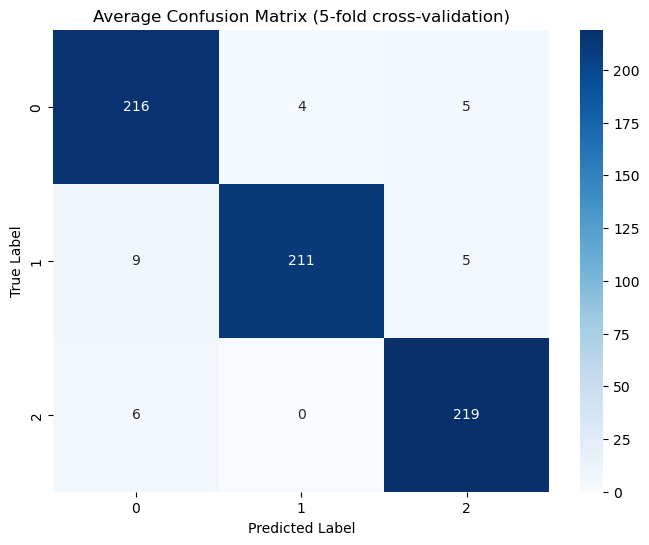

In [16]:
# Calculate and print average accuracy and F1 score
average_accuracy = accuracy_score(all_test_labels, all_test_outputs)
average_f1 = f1_score(all_test_labels, all_test_outputs, average='weighted')
print(f"\nAverage Accuracy: {average_accuracy:.4f}, Average F1 Score: {average_f1:.4f}")

# Plot confusion matrix
conf_matrix = confusion_matrix(all_test_labels, all_test_outputs)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Average Confusion Matrix (5-fold cross-validation)')
plt.show()